In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator


## Major Goals and Features

- __Code structure applicable to all model selection algorithms__.
   - Current implementation for algebraic model seleciton, but can be easily extended to any other model selection algorithm.
- __Model-agnostic code dev__: Develop a code base that is agnostic to the model, and optimizers used.
  - Other models can fit in the same framework without adding extra code.
  - End users face the same interface regardless of models/algorithms used and the implementation details are hidden, but easily accessible.
  - Helps with easy experimentation to find problem-specific optimal models.
- __Defining Library terms__
  - Predefined library classes for popular library functions, like Polynomials, rationals etc.
  - Custom library class to support library functions manually entered/loaded from an external file.
- __OOP__: Objected Oriented Programming.
    - The base class is abstract and all classes are derived from the abstract class with some common methods like fit and transform method. 
    -  Adds more flexibility, and avoids code duplication through inheritance, overloading etc.
    -  Models, optmizers, library terms etc can be passed as objects to the main class (or pipeline object) exploiting python's duck typing. 
- __Pandas__ for visualization and efficient data manipulation. Also aids in plotting, stat etc. 

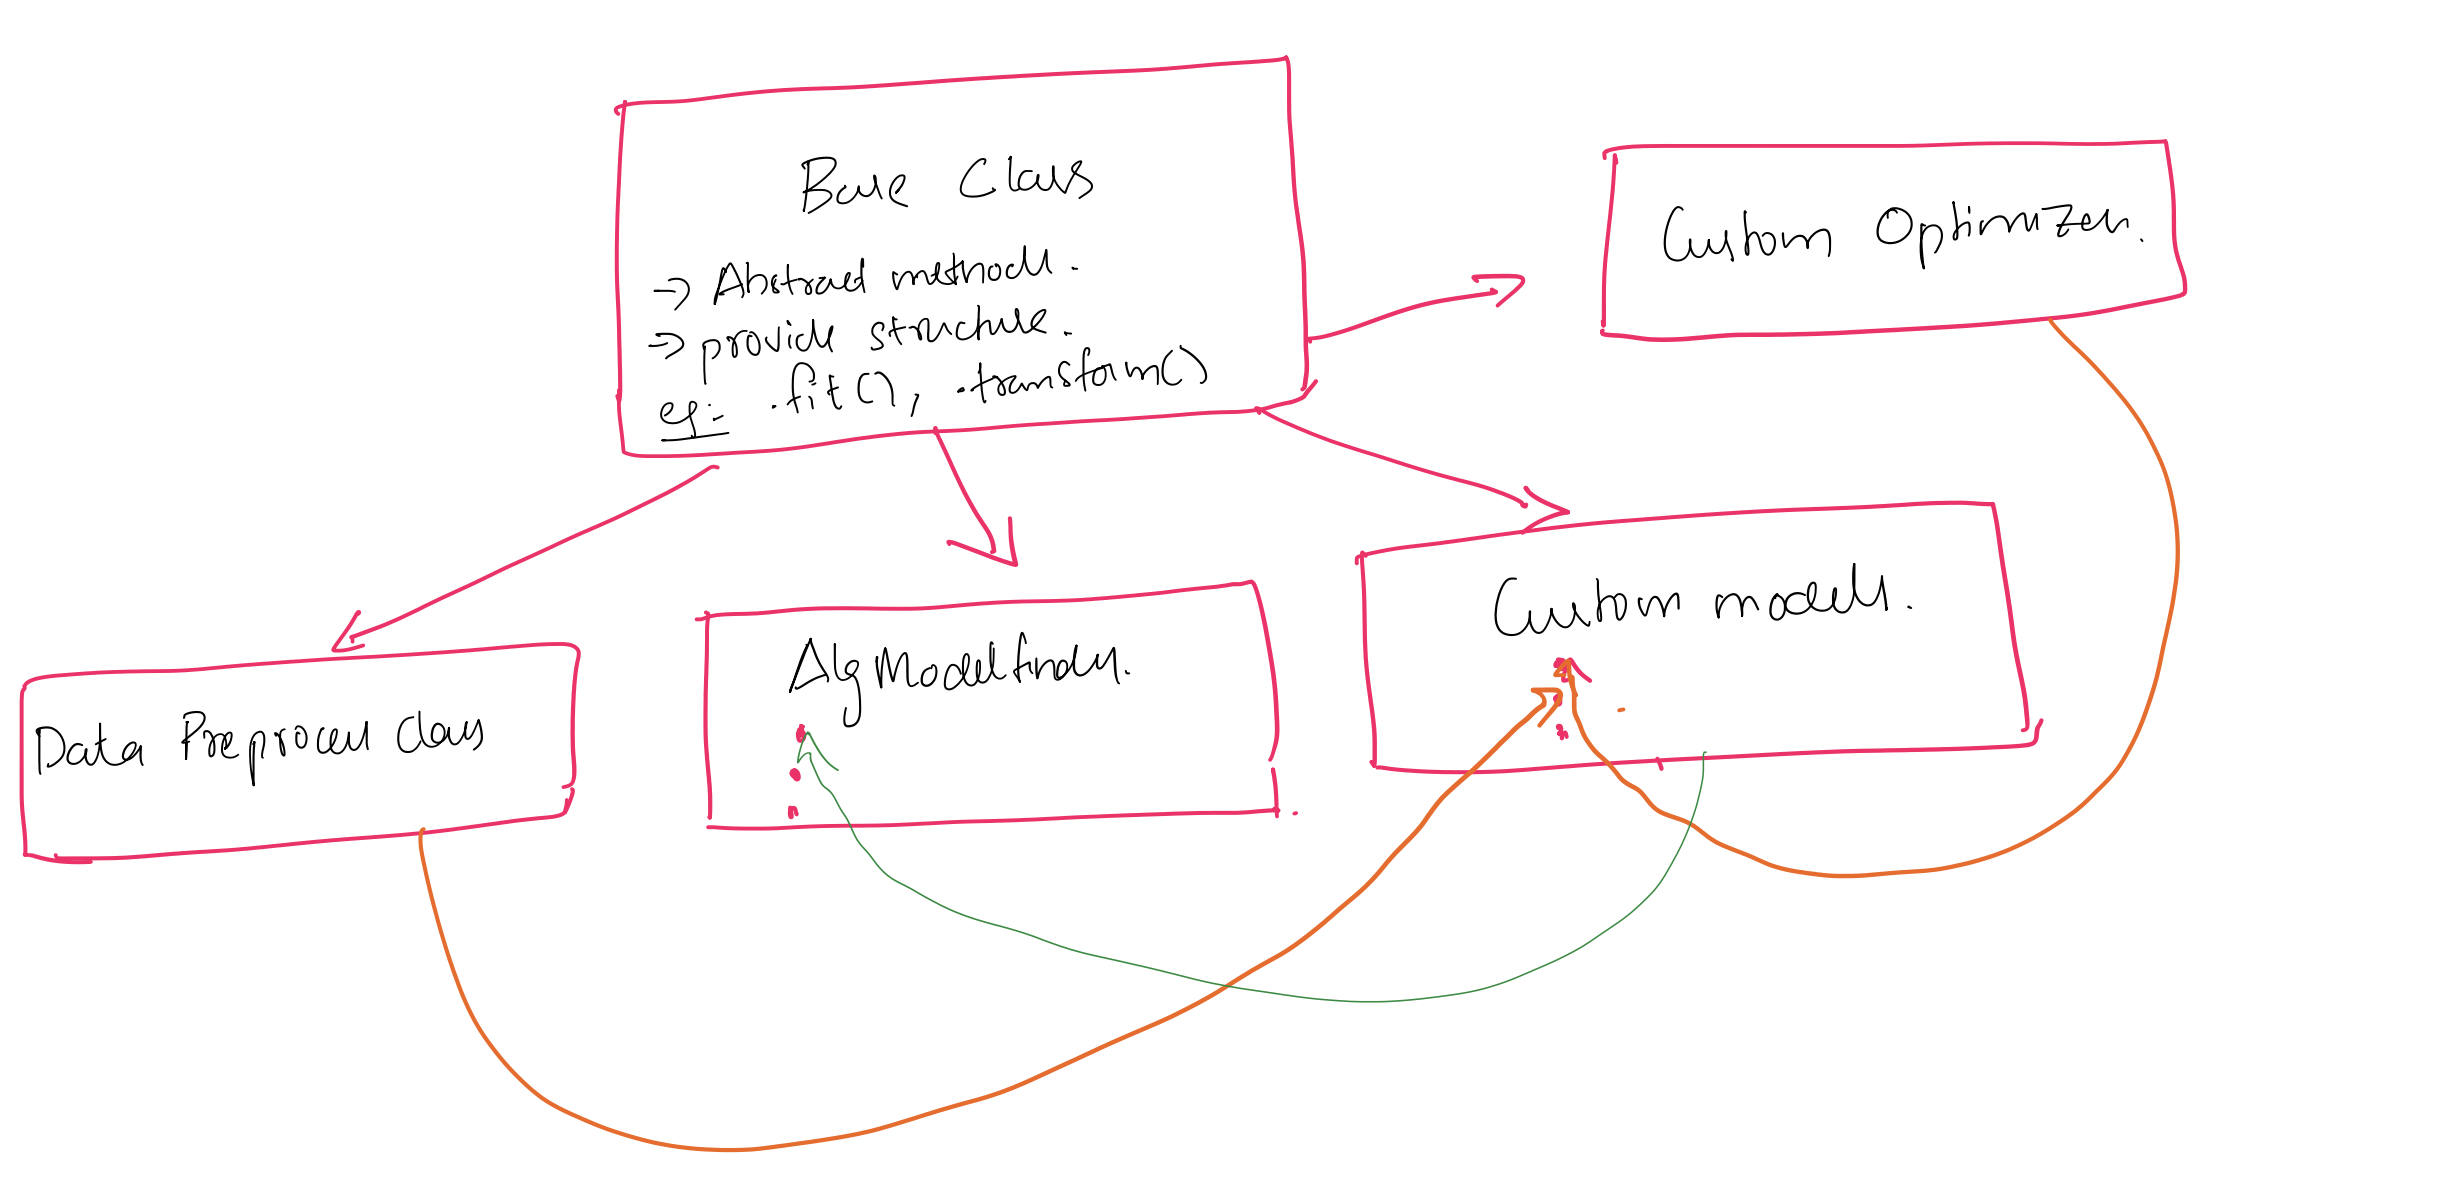

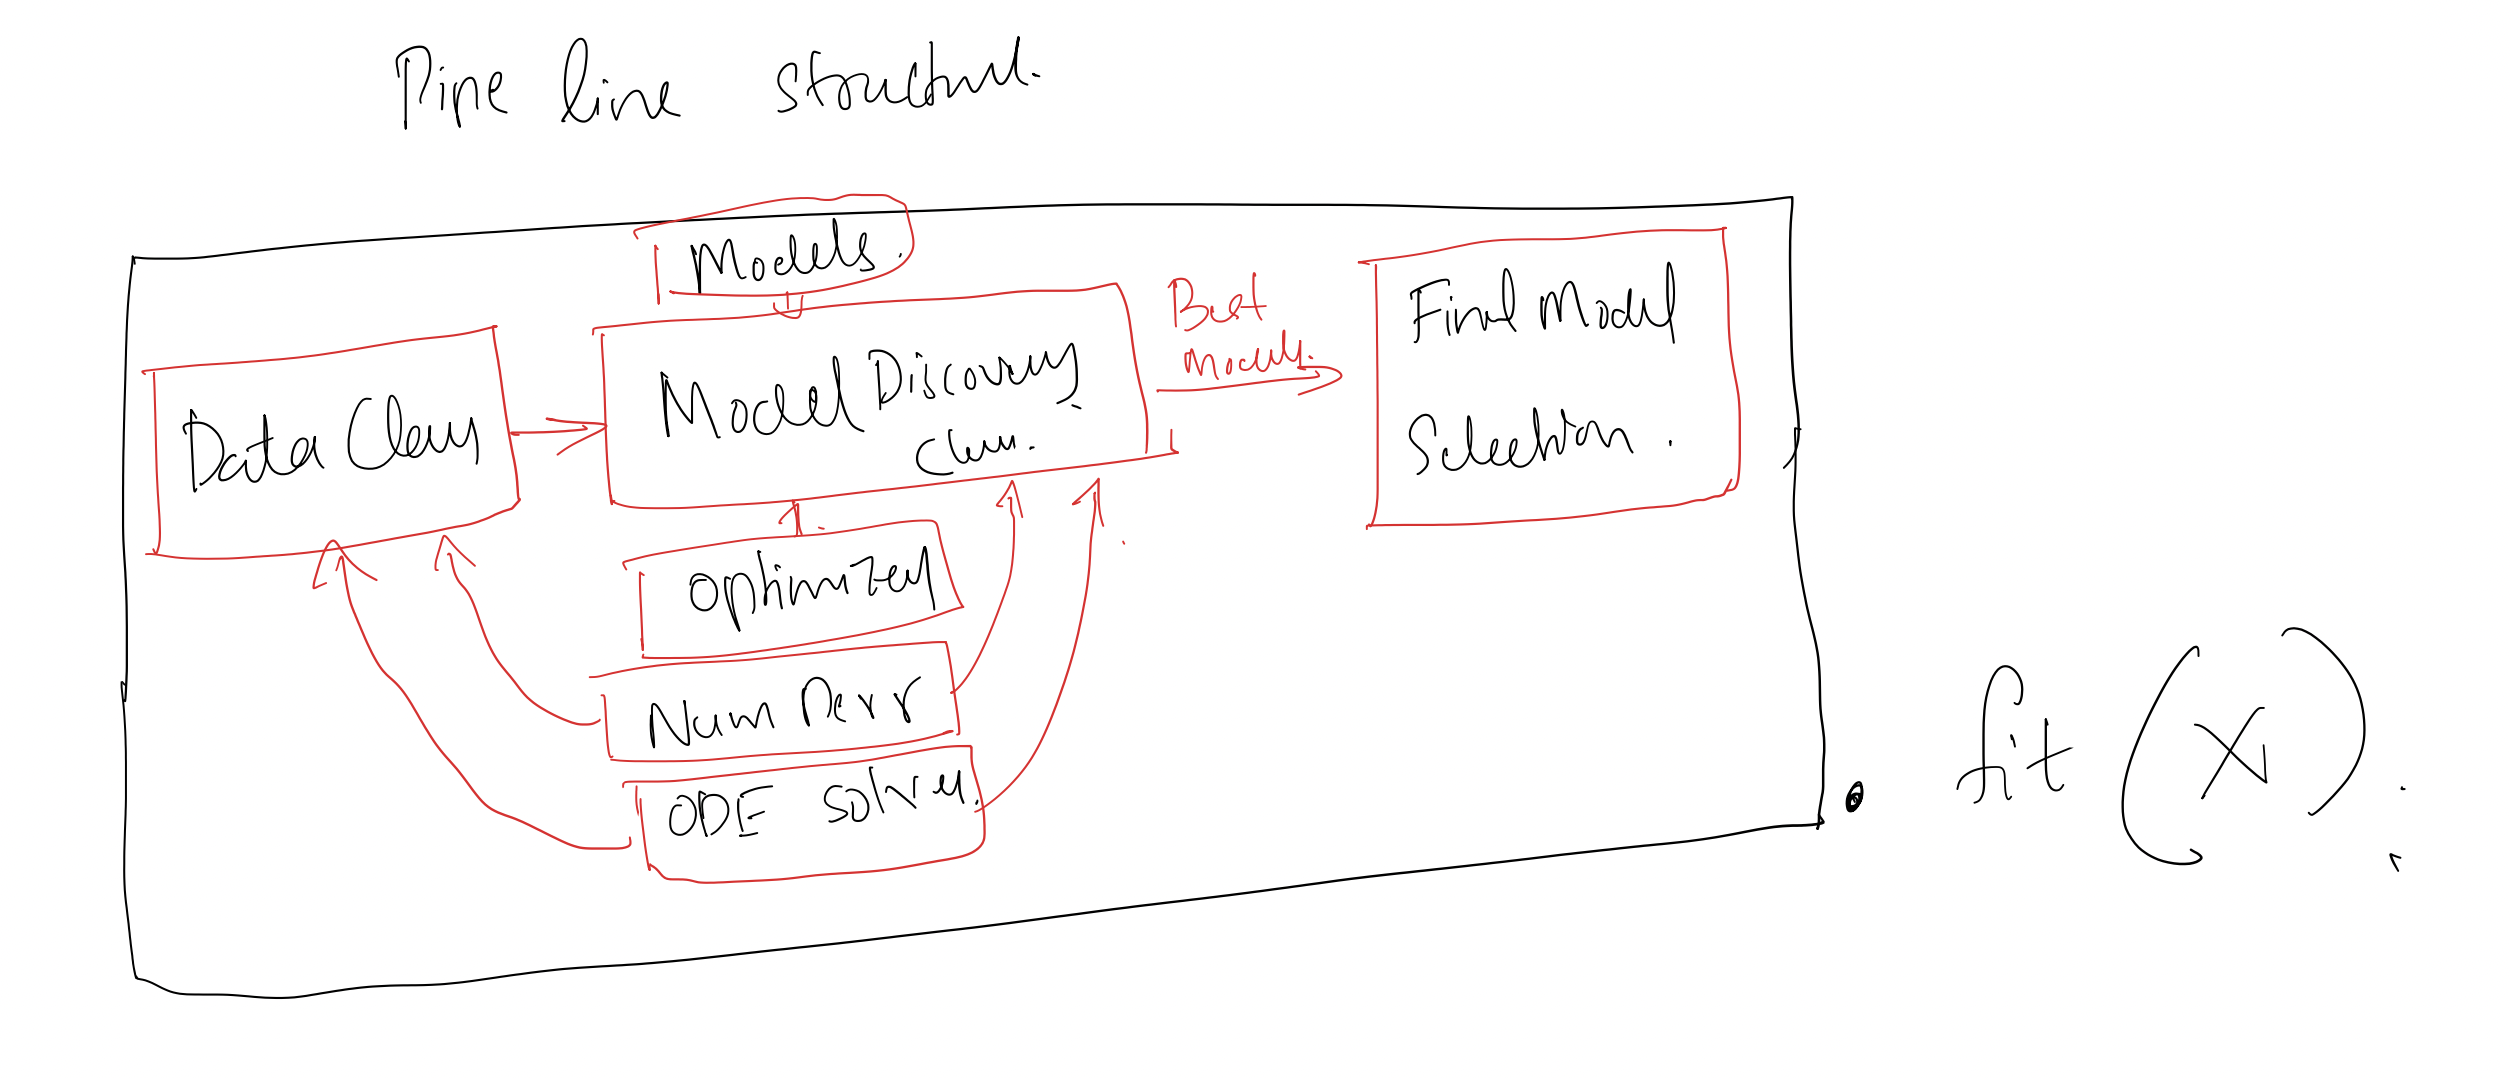

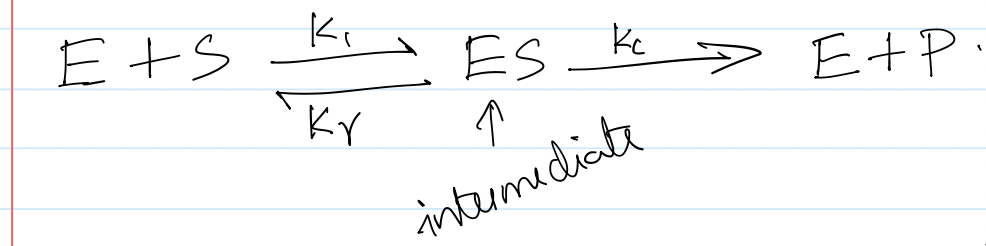

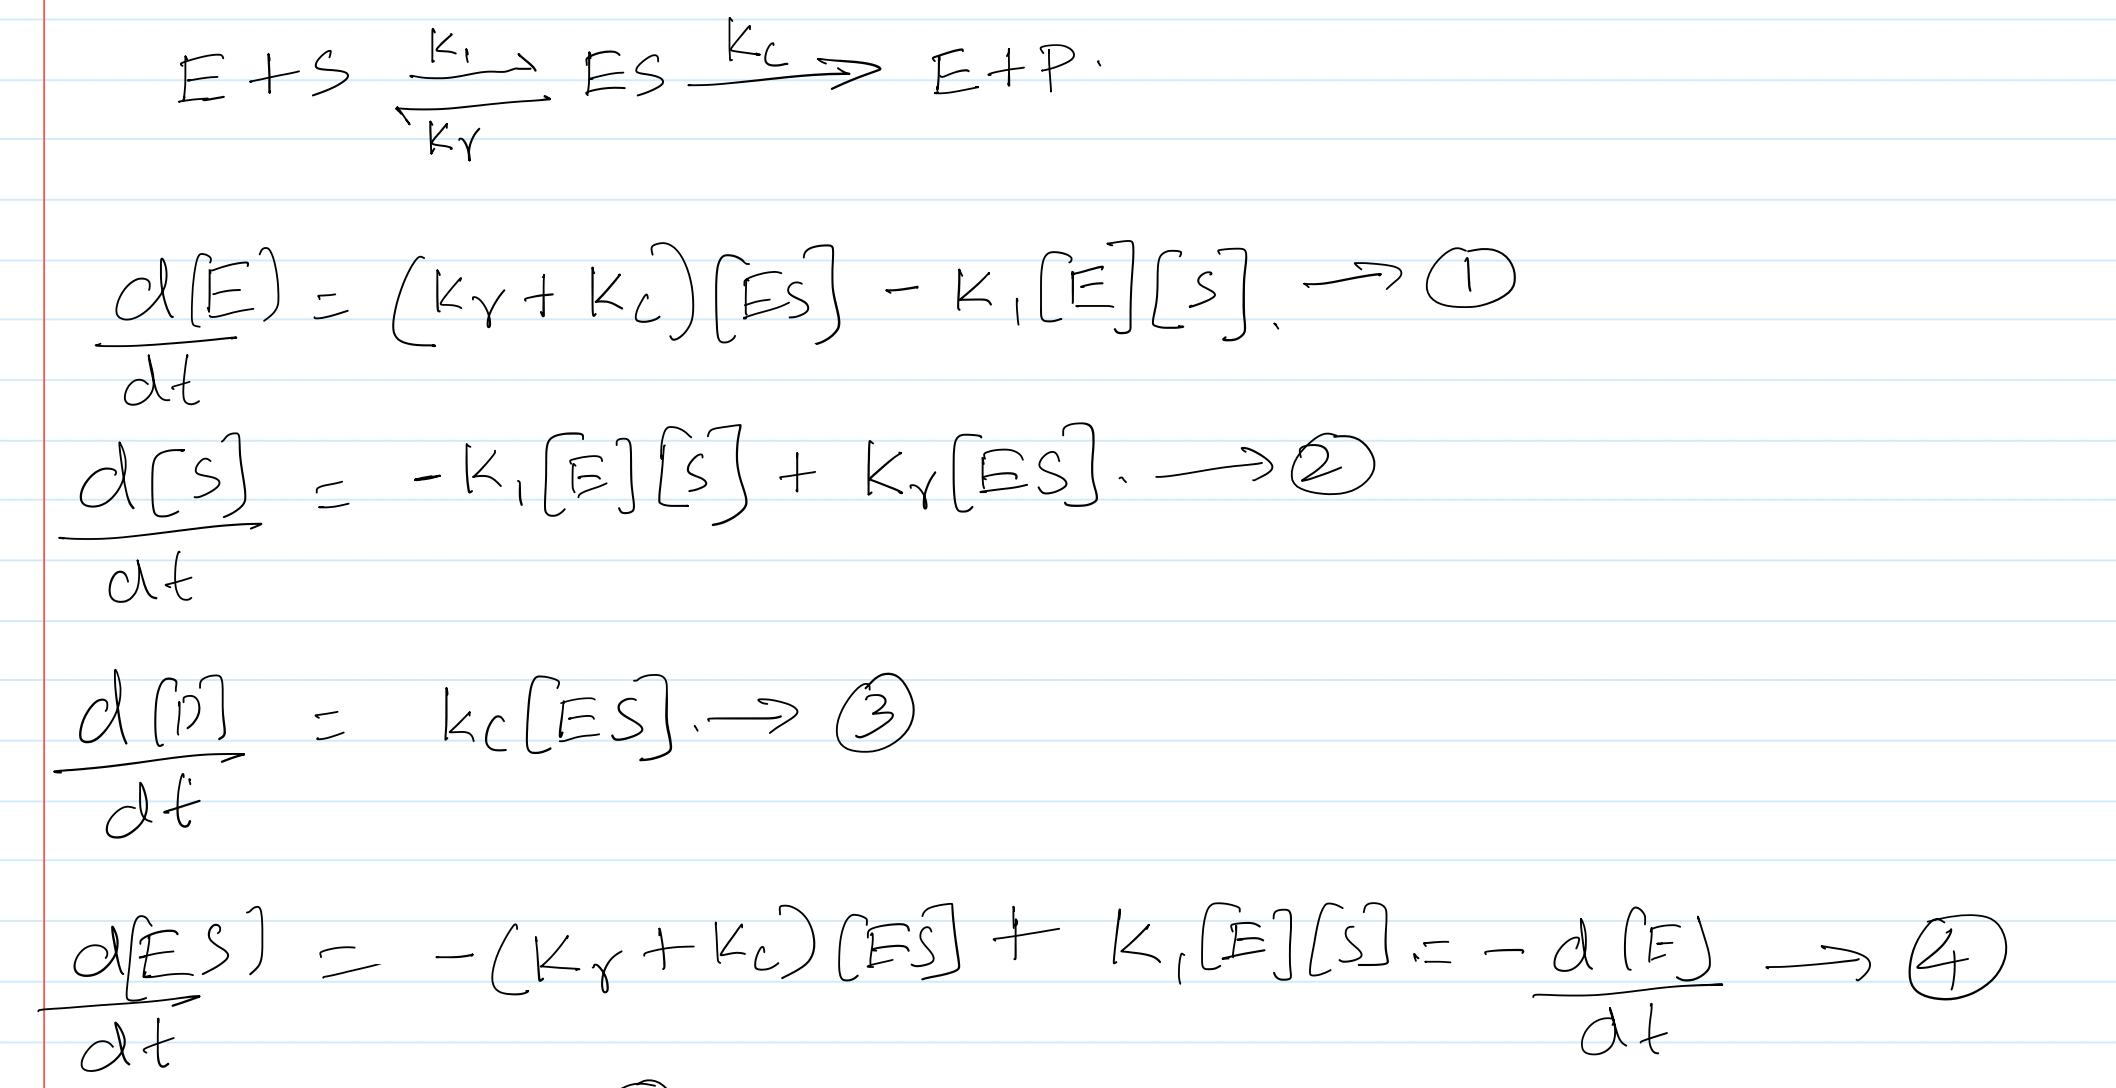

### Michaelis Mentin approximation

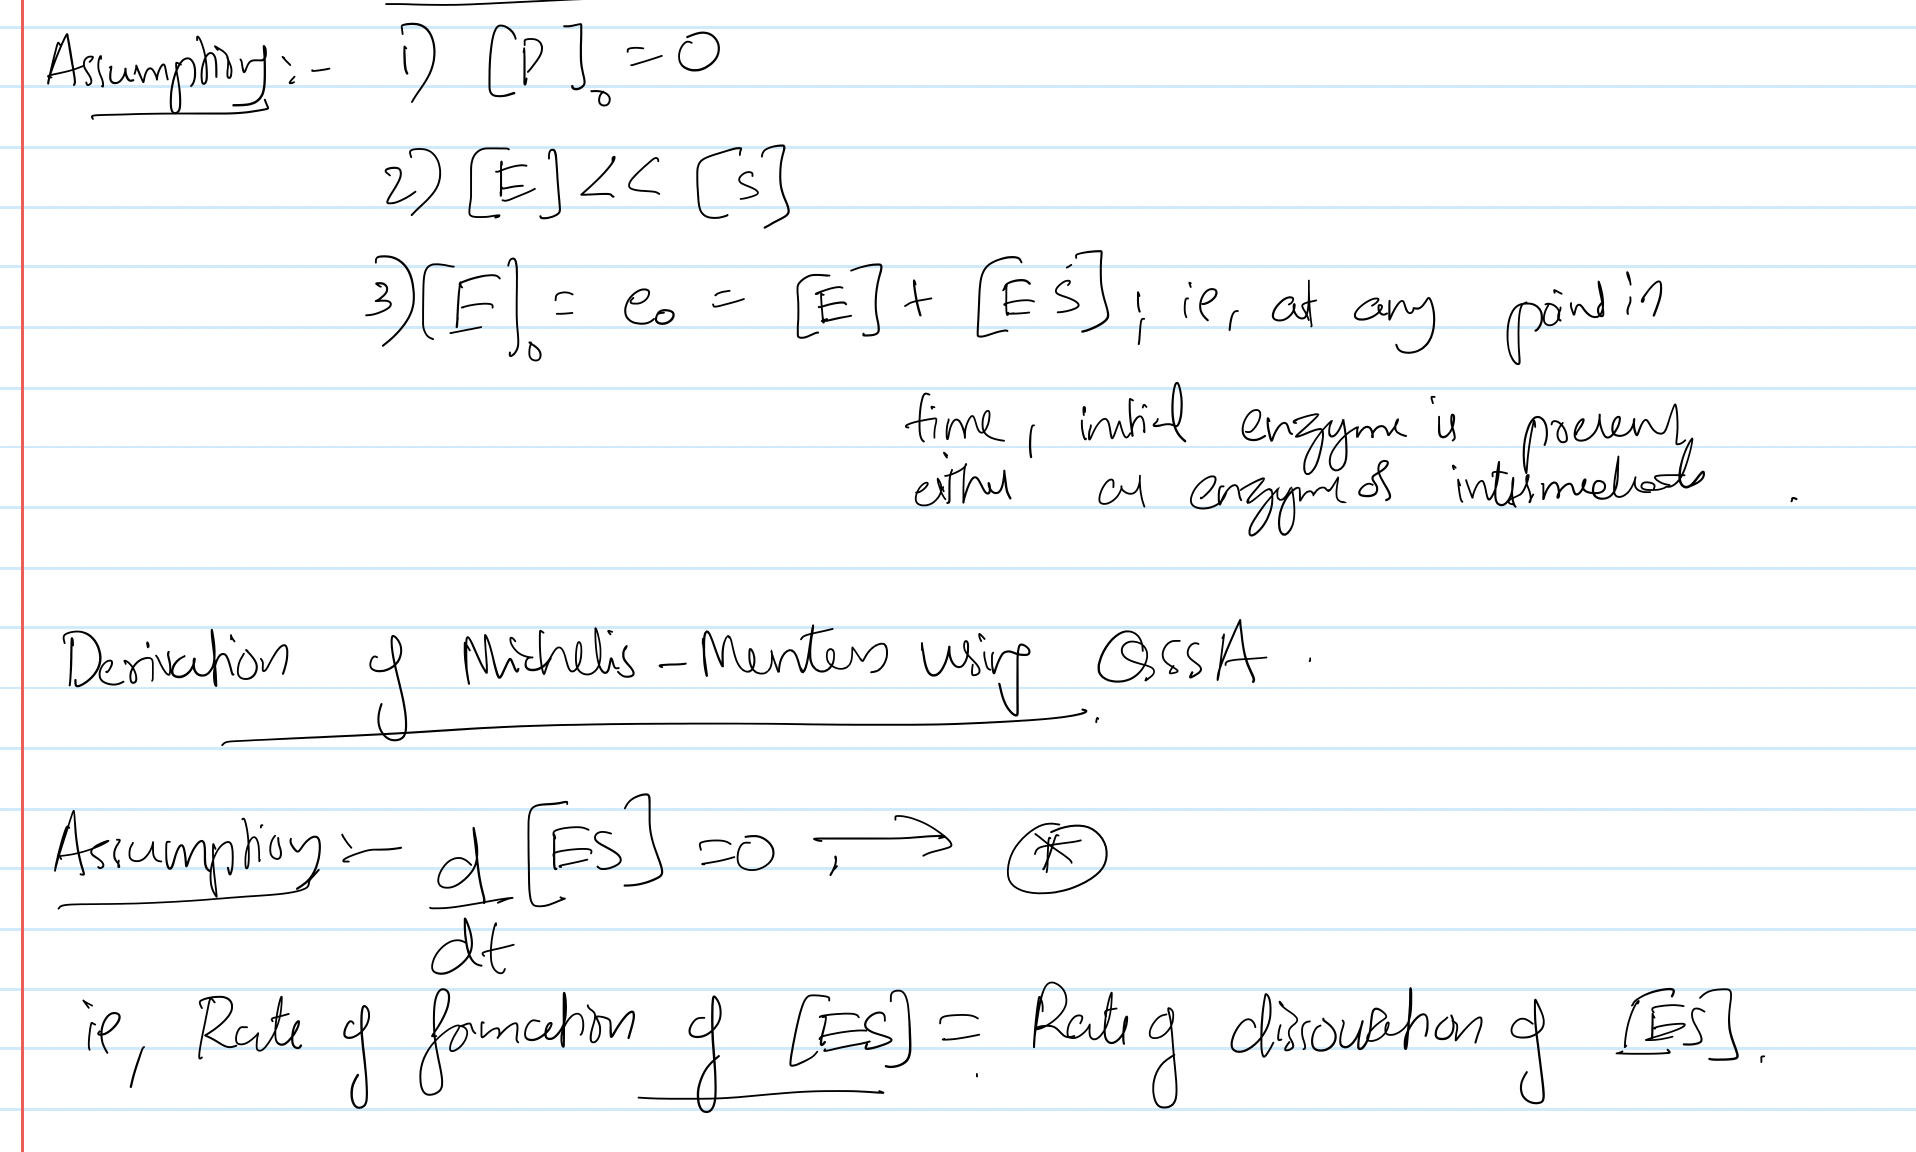

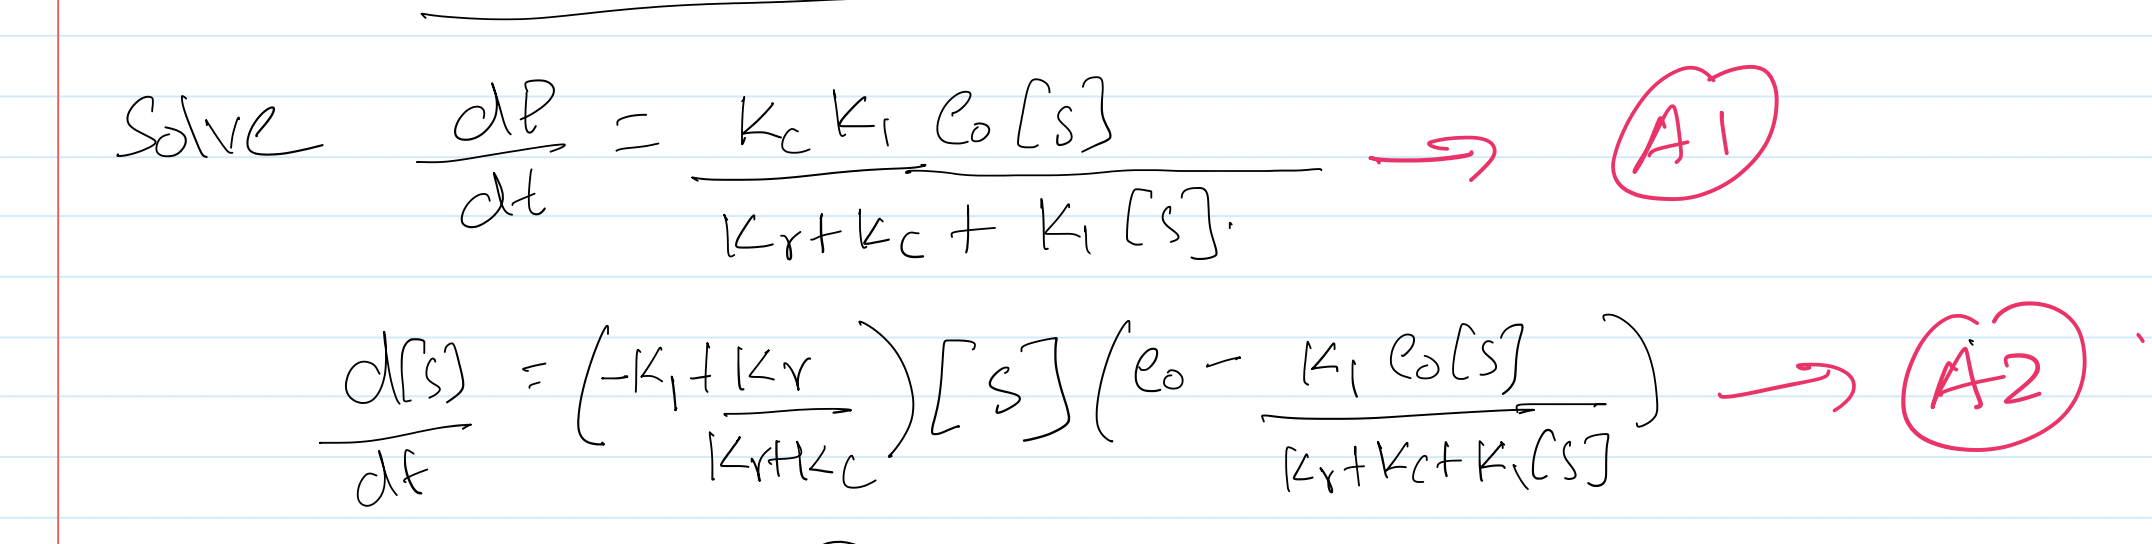

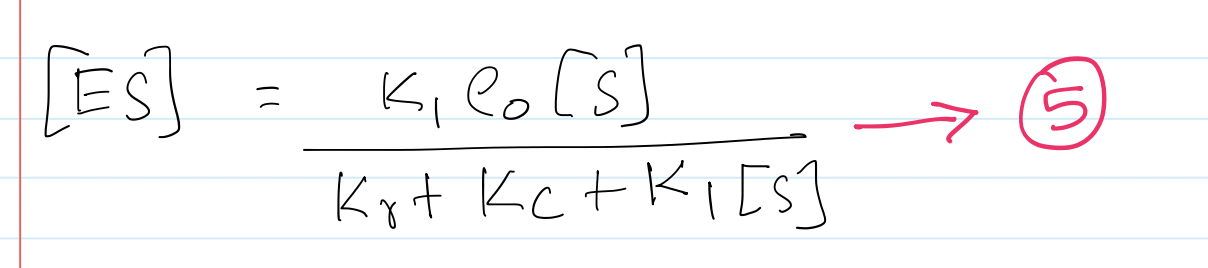

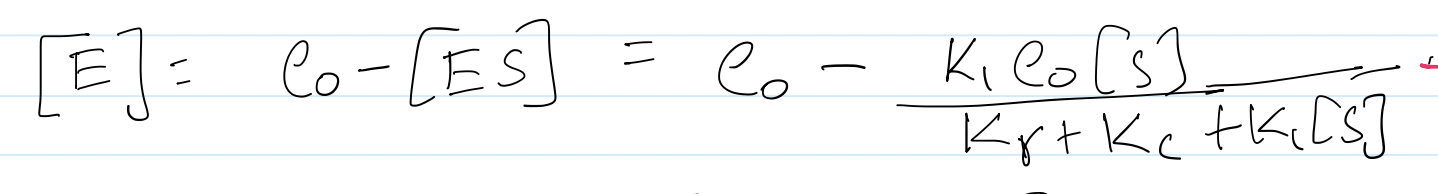


2) Construct data for dense, evenly spaced sampling and plot
3) Construct data for sparse sampling, evenly spaced
4) Construct data for dense initial sampling, sparse final sampling
5) Construct data for randomly selected timing of samples

Combinatorial library construction:

from itertools import combinations, chain, product
import sympy as sp

def powerset(symlst):
    s = list(symlst)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def makeOrder(maxOrder, numsym):
    return list(product(np.arange(maxOrder+1), repeat = numsym))

def makeLibTerms(symlst, maxOrder):
    ordlst = makeOrder(maxOrder, len(symlst))
    return list(map(np.prod, [tuple(map(sp.Pow, symlst, i)) for i in ordlst]))

makeLibTerms(sp.symbols('S, E, ES, P'), 3)

### Generating data using MM 

#### Loading intial conditions

In [2]:
k_rates_df = pd.read_csv("parameters/k_rates_param.csv")

In [3]:
k_rates_df

# k_rates_df["k"][0] = 2
# k_rates_df["kr"][0] = 1
# k_rates_df["kcat"][0] = 1.5


k         kr       kcat
0 2.12456000 1.10124000 1.50930000

#### Loading params

In [4]:
IC_df = pd.read_csv("parameters/init_cond.csv")
IC_df = IC_df.drop([2,4,5,8], axis = 0)
# IC_df = IC_df[0:7]
IC_df

S  E  ES  P
0 3.00000000  2   0  0
1 4.00000000  2   0  0
3 6.00000000  2   0  0
6 8.50000000  2   0  0
7 9.00000000  2   0  0

In [5]:
from dae_finder import solveMM, plotToy_MM, plotToyEnz

#### Plotting solutions to different IC

In [6]:
refinement_level = 2
final_time = 4
num_time_points = 100
t_span = (0, final_time)
time_grid_1 = np.linspace(0, final_time, num_time_points)
data_matrix_df_list = []

def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]

for k_rate_index in k_rates_df.index:
    k_rates = k_rates_df.loc[k_rate_index]
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        # data_matrix_df_list.append(solveMM(IC, k_rates, time_grid_1, "dense"))
        sol = solveMM(IC, k_rates, time_grid_1, "dense")
        sol_df = pd.DataFrame(sol, columns=IC.keys())
        sol_df["t"] = time_grid_1
        data_matrix_df_list.append(sol_df.rename(columns=dict(zip(sol_df.columns, get_block_symbol(sol_df.columns)))))

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

[S]        [E]       [ES]        [P]        [t]
0   3.00000000 0.58113893 1.41886107 0.00000000 0.00000000
1   2.91384179 0.59322556 1.40677444 0.08615821 0.04040404
2   2.82843283 0.60571374 1.39428626 0.17156717 0.08080808
3   2.74379804 0.61861844 1.38138156 0.25620196 0.12121212
4   2.65996329 0.63195494 1.36804506 0.34003671 0.16161616
..         ...        ...        ...        ...        ...
495 0.64744396 1.30983033 0.69016967 8.35255604 3.83838384
496 0.60625254 1.33923298 0.66076702 8.39374746 3.87878788
497 0.56685405 1.36861804 0.63138196 8.43314595 3.91919192
498 0.52924475 1.39789740 0.60210260 8.47075525 3.95959596
499 0.49341544 1.42698048 0.57301952 8.50658456 4.00000000

[500 rows x 5 columns]

#### Adding noise

In [7]:
from dae_finder import add_noise_to_df
noise_perc = 0


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["[t]"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["[t]"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

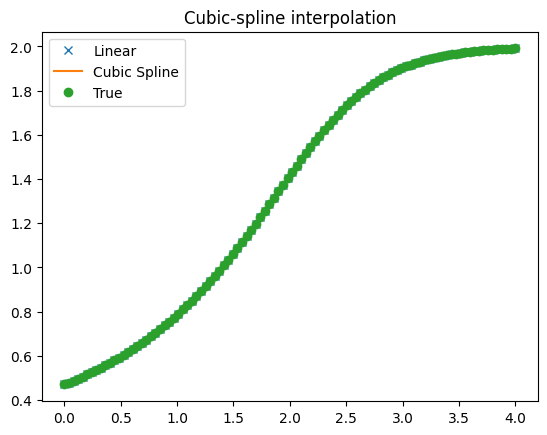

In [8]:
from scipy import interpolate
from matplotlib import pyplot as plt

#smoothing parameter: when equal weightage: num_data_points * std of data
s_param = num_time_points * (0.01*noise_perc*data_matrix_df_list[1].std()["[E]"])**2

tck = interpolate.splrep(data_matrix_df_list[1]["[t]"], data_matrix_df_list[1]["[E]"], s=s_param)
t_eval_new = np.linspace(t_span[0], t_span[1], 4*num_time_points)
x_new = interpolate.splev(t_eval_new, tck, der=0)

plt.figure()
plt.plot(data_matrix_df_list[1]["[t]"], data_matrix_df_list[1]["[E]"], "x", t_eval_new, x_new,
        data_matrix_df[num_time_points:2*num_time_points]["[t]"], data_matrix_df[num_time_points:2*num_time_points]["[E]"], "o")
plt.legend(['Linear', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

## Smoothing data and finding derivatives

### Sampling more from the transition region

In [9]:
num_smoothed_points = num_time_points*4
t_eval_new = np.linspace(data_matrix_df_list[0]["[t]"].iloc[0], data_matrix_df_list[0]["[t]"].iloc[-1], num_smoothed_points)


amplify_left = 0.5
amplify_right = 3.0
amplify_factor = 1
t_length = t_span[1] - t_span[0]

num_left_points = int(num_smoothed_points * (amplify_left-t_span[0])/t_length)
num_right_points = int(num_smoothed_points * (t_span[1] - amplify_right)/t_length)

t_left = t_eval_new[:num_left_points]
t_right = t_eval_new[-num_right_points:]
t_middle = np.linspace(t_eval_new[num_left_points], t_eval_new[-(num_right_points+1)],
                       amplify_factor*(len(t_eval_new) - (num_left_points + num_right_points) ))

t_eval_new = np.concatenate((t_left, t_middle, t_right))

In [10]:
from dae_finder import smooth_data

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                          eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
    data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)

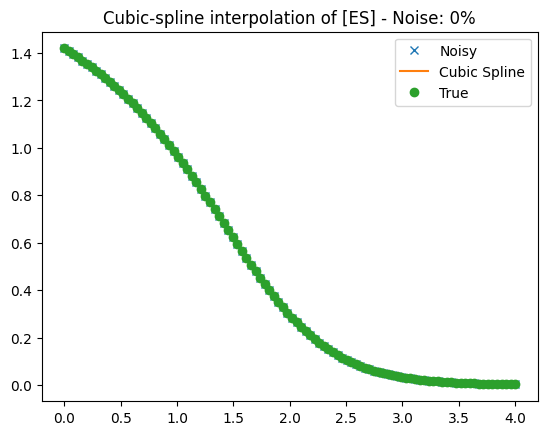

In [11]:

ind = 0
feature_ = "[ES]"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["[t]"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["[t]"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["[t]"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

<Axes: >

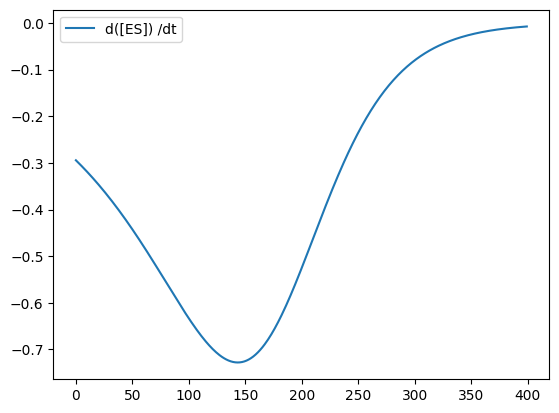

In [12]:
data_matrix_smooth_df_list[0][["d([ES]) /dt"]].plot()

In [13]:
data_matrix_df_smooth_appended

[t]        [S]  d([S]) /dt        [E]  d([E]) /dt       [ES]  \
0    0.00000000 3.00000000 -2.14148347 0.58113893  0.29429749 1.41886107   
1    0.01002506 2.97855386 -2.13701541 0.58410122  0.29668341 1.41589878   
2    0.02005013 2.95715270 -2.13250967 0.58708755  0.29909201 1.41291245   
3    0.03007519 2.93579690 -2.12796625 0.59009813  0.30152328 1.40990187   
4    0.04010025 2.91448684 -2.12338514 0.59313320  0.30397722 1.40686680   
...         ...        ...         ...        ...         ...        ...   
1995 3.95989975 0.52896873 -0.90842886 1.39811691  0.72257403 0.60188309   
1996 3.96992481 0.51991644 -0.89750636 1.40535447  0.72129520 0.59464553   
1997 3.97994987 0.51097356 -0.88659965 1.41257851  0.71987767 0.58742149   
1998 3.98997494 0.50213995 -0.87570872 1.41978764  0.71832144 0.58021236   
1999 4.00000000 0.49341544 -0.86483357 1.42698048  0.71662652 0.57301952   

      d([ES]) /dt         [P]  d([P]) /dt  
0     -0.29429749 -0.00000000  2.14148347  
1     -0.29668341  0.02144614  2.13701541  
2     -0.29909201  0.04284730  2.13250967  
3     -0.30152328  0.06420310  2.12796625  
4     -0.30397722  0.08551316  2.12338514  
...           ...         ...         ...  
1995  -0.72257403  8.47103127  0.90842886  
1996  -0.72129520  8.48008356  0.89750636  
1997  -0.71987767  8.48902644  0.88659965  
1998  -0.71832144  8.49786005  0.87570872  
1999  -0.71662652  8.50658456  0.86483357  

[2000 rows x 9 columns]

## Forming candidate library

In [14]:
from dae_finder import PolyFeatureMatrix

poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)


candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

[S]        [E]       [ES]         [P]      [S]^2    [S] [E]  \
0    3.00000000 0.58113893 1.41886107 -0.00000000 9.00000000 1.74341679   
1    2.97855386 0.58410122 1.41589878  0.02144614 8.87178309 1.73977695   
2    2.95715270 0.58708755 1.41291245  0.04284730 8.74475209 1.73610752   
3    2.93579690 0.59009813 1.40990187  0.06420310 8.61890343 1.73240826   
4    2.91448684 0.59313320 1.40686680  0.08551316 8.49423351 1.72867891   
...         ...        ...        ...         ...        ...        ...   
1995 0.52896873 1.39811691 0.60188309  8.47103127 0.27980792 0.73956013   
1996 0.51991644 1.40535447 0.59464553  8.48008356 0.27031310 0.73066689   
1997 0.51097356 1.41257851 0.58742149  8.48902644 0.26109398 0.72179027   
1998 0.50213995 1.41978764 0.58021236  8.49786005 0.25214453 0.71293210   
1999 0.49341544 1.42698048 0.57301952  8.50658456 0.24345880 0.70409420   

       [S] [ES]     [S] [P]      [E]^2   [E] [ES]  ...      [E]^3  [E]^2 [ES]  \
0    4.25658321 -0.00000000 0.33772246 0.82455540  ... 0.19626367  0.47918125   
1    4.21733077  0.06387849 0.34117424 0.82702821  ... 0.19928029  0.48306819   
2    4.17819788  0.12670601 0.34467179 0.82950331  ... 0.20235251  0.48699106   
3    4.13918554  0.18848727 0.34821580 0.83198046  ... 0.20548149  0.49095011   
4    4.10029476  0.24922699 0.35180699 0.83445941  ... 0.20866841  0.49494558   
...         ...         ...        ...        ...  ...        ...         ...   
1995 0.31837733  4.48091066 1.95473090 0.84150292  ... 2.73294233  1.17651947   
1996 0.30916599  4.40893484 1.97502118 0.83568776  ... 2.77560484  1.17443752   
1997 0.30015685  4.33766809 1.99537804 0.82977898  ... 2.81862813  1.17212795   
1998 0.29134781  4.26711503 2.01579695 0.82377834  ... 2.86200359  1.16959030   
1999 0.28273668  4.19728018 2.03627329 0.81768767  ... 2.90572223  1.16682434   

       [E]^2 [P]  [E] [ES]^2  [E] [ES] [P]    [E] [P]^2     [ES]^3  \
0    -0.00000000  1.16992956   -0.00000000   0.00000000 2.85640391   
1     0.00731687  1.17098823    0.01773656   0.00026865 2.83855047   
2     0.01476826  1.17201555    0.03554198   0.00107783 2.82062766   
3     0.02235653  1.17301080    0.05341573   0.00243241 2.80263577   
4     0.03008413  1.17397324    0.07135726   0.00433729 2.78457514   
...          ...         ...           ...          ...        ...   
1995 16.55858657  0.50648638    7.12839758 100.32659173 0.21804012   
1996 16.74834464  0.49693799    7.08670200 101.06159361 0.21026863   
1997 16.93881693  0.48743000    7.04401566 101.79544993 0.20269802   
1998 17.12996034  0.47796637    7.00035301 102.52801291 0.19532639   
1999 17.32173091  0.46855100    6.95572931 103.25913410 0.18815175   

      [ES]^2 [P]  [ES] [P]^2        [P]^3  
0    -0.00000000  0.00000000  -0.00000000  
1     0.04299457  0.00065122   0.00000986  
2     0.08553699  0.00259395   0.00007866  
3     0.12762442  0.00581167   0.00026465  
4     0.16925400  0.01028772   0.00062532  
...          ...         ...          ...  
1995  3.06874333 43.19014978 607.86740242  
1996  2.99858561 42.76204084 609.81821915  
1997  2.92925750 42.33168974 611.74954942  
1998  2.86077383 41.89923791 613.66128237  
1999  2.79314871 41.46482760 615.55330892  

[2000 rows x 34 columns]

### Scaling the candidate library

In [15]:
#scaling the candidate columns to set std of 1
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
# scaled_cand_lib_test= pd.DataFrame(s_scaler.transform(candidate_lib_test), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

# feature = "ES"
# X_ = scaled_cand_lib.drop([feature], axis=1)
# y_ = scaled_cand_lib[feature]

# Testing with SVD

### Noise = 0

In [16]:
#scaling the candidate columns to set std of 1
from sklearn.preprocessing import StandardScaler
s_scaler_mean = StandardScaler(with_std=False, with_mean=True)
s_scaler_both = StandardScaler(with_std=True, with_mean=True)

mean_cent_data_matrix_df_smooth = pd.DataFrame(s_scaler_mean.fit_transform(data_matrix_df_smooth), columns=s_scaler_mean.feature_names_in_)

#Making the polynomial candidate library
from dae_finder import PolyFeatureMatrix

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
#shuffling the rows of the data frame
mean_candidate_lib_full = candidate_lib_full.sample(frac=1).reset_index(drop=True)
candidate_lib = candidate_lib_full

mean_candidate_lib_full = poly_feature_ob.fit_transform(mean_cent_data_matrix_df_smooth)
#shuffling the rows of the data frame
mean_candidate_lib_full = mean_candidate_lib_full.sample(frac=1).reset_index(drop=True)
mean_candidate_lib = mean_candidate_lib_full

candidate_lib_E_rem_full = poly_feature_ob.fit_transform(data_matrix_df_smooth.drop(["[E]"],axis=1))
#shuffling the rows of the data frame
# candidate_lib_E_rem_full = candidate_lib_E_rem_full.sample(frac=1).reset_index(drop=True)
candidate_lib_E_rem = candidate_lib_E_rem_full


scaled_cand_lib_mean = pd.DataFrame(s_scaler_mean.fit_transform(candidate_lib_full), columns=s_scaler_mean.feature_names_in_)

all_scaled_cand_lib = pd.DataFrame(s_scaler_both.fit_transform(candidate_lib_full), columns=s_scaler_both.feature_names_in_)
# scaled_cand_lib_test= pd.DataFrame(s_scaler.transform(candidate_lib_test), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib_mean.columns:
    scaled_cand_lib_mean = scaled_cand_lib_mean.drop(['1'], axis=1)
if '1' in candidate_lib.columns:
    candidate_lib = candidate_lib.drop(['1'], axis=1)

if '1' in scaled_cand_lib.columns:
    scaled_cand_lib = scaled_cand_lib.drop(['1'], axis=1)

if '1' in all_scaled_cand_lib.columns:
    all_scaled_cand_lib = all_scaled_cand_lib.drop(['1'], axis=1)


if '1' in mean_candidate_lib.columns:
    mean_candidate_lib = mean_candidate_lib.drop(['1'], axis=1)


In [17]:
data_matrix_df_smooth

[S]        [E]       [ES]         [P]
0    3.00000000 0.58113893 1.41886107 -0.00000000
1    2.97855386 0.58410122 1.41589878  0.02144614
2    2.95715270 0.58708755 1.41291245  0.04284730
3    2.93579690 0.59009813 1.40990187  0.06420310
4    2.91448684 0.59313320 1.40686680  0.08551316
...         ...        ...        ...         ...
1995 0.52896873 1.39811691 0.60188309  8.47103127
1996 0.51991644 1.40535447 0.59464553  8.48008356
1997 0.51097356 1.41257851 0.58742149  8.48902644
1998 0.50213995 1.41978764 0.58021236  8.49786005
1999 0.49341544 1.42698048 0.57301952  8.50658456

[2000 rows x 4 columns]

In [18]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)

pca_2 = decomposition.PCA()
pca_2.fit(mean_candidate_lib)

pca_3 = decomposition.PCA()
pca_3.fit(data_matrix_df_smooth)

pca_4 = decomposition.PCA()
pca_4.fit(data_matrix_df_smooth.drop(["[E]"],axis=1))

pca_5 = decomposition.PCA()
pca_5.fit(candidate_lib_E_rem)


singular_values = pca_1.singular_values_
mean_singular_values = pca_2.singular_values_

var_expl_ratio = pca_1.explained_variance_ratio_
mean_var_expl_ratio = pca_2.explained_variance_ratio_
data_var_expl_ratio = pca_3.explained_variance_ratio_
data_var_expl_ratio_E = pca_4.explained_variance_

var_expl_ratio_E_rem = pca_5.explained_variance_


In [19]:
pca_1.explained_variance_ratio_

array([6.20459635e-01, 3.35016872e-01, 3.81841949e-02, 4.49632502e-03,
       1.37318903e-03, 2.44636939e-04, 1.44793650e-04, 5.91411536e-05,
       1.56921133e-05, 4.14210967e-06, 7.71140100e-07, 4.10014840e-07,
       1.57315190e-07, 3.64937174e-08, 3.96680992e-09, 1.64628092e-19,
       6.75816308e-21, 9.95609649e-22, 1.02877433e-22, 4.19064507e-33,
       3.87310839e-33, 3.87310839e-33, 3.87310839e-33, 3.87310839e-33,
       3.87310839e-33, 3.87310839e-33, 3.87310839e-33, 3.87310839e-33,
       3.87310839e-33, 3.87310839e-33, 3.87310839e-33, 3.87310839e-33,
       3.87310839e-33, 3.87310839e-33, 3.50702411e-33])

In [20]:
pca_2.explained_variance_ratio_

array([8.26746747e-01, 1.49485027e-01, 1.06849573e-02, 5.85025013e-03,
       3.46008321e-03, 1.81949620e-03, 1.00742832e-03, 5.47503366e-04,
       1.97089508e-04, 1.16275437e-04, 5.27656648e-05, 2.45385720e-05,
       5.96630828e-06, 1.80206746e-06, 6.98087483e-08, 8.81482175e-20,
       6.79441067e-21, 1.69071515e-21, 1.25709754e-22, 5.46304073e-33,
       5.46304073e-33, 5.46304073e-33, 5.46304073e-33, 5.46304073e-33,
       5.46304073e-33, 5.46304073e-33, 5.46304073e-33, 5.46304073e-33,
       5.46304073e-33, 5.46304073e-33, 5.46304073e-33, 5.46304073e-33,
       5.46304073e-33, 5.46304073e-33])

In [21]:
pca_3.explained_variance_ratio_

array([7.20210176e-01, 2.66487134e-01, 1.33026895e-02, 8.27918111e-33])

In [22]:
pca_2.singular_values_

array([2.64658578e+03, 1.12537839e+03, 3.00875013e+02, 2.22631670e+02,
       1.71215468e+02, 1.24158170e+02, 9.23861364e+01, 6.81072153e+01,
       4.08631159e+01, 3.13865598e+01, 2.11434296e+01, 1.44186423e+01,
       7.10972121e+00, 3.90737640e+00, 7.69050134e-01, 8.64184542e-07,
       2.39925066e-07, 1.19683684e-07, 3.26350449e-08, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13, 2.15137910e-13, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13, 2.15137910e-13, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13, 2.15137910e-13, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13])

In [23]:
candid_lib_sing_values = np.linalg.svd(candidate_lib)[1]
mean_cent_candid_lib_sing_values = np.linalg.svd(mean_candidate_lib)[1]


scaled_cand_lib_mean_sing_values = np.linalg.svd(scaled_cand_lib_mean)[1]

column_scaled_sing_values = np.linalg.svd(scaled_cand_lib)[1]

all_scaled_sing_values = np.linalg.svd(all_scaled_cand_lib)[1]

data_matrix_sing_values = np.linalg.svd(data_matrix_df_smooth)[1]

candid_lib_E_rem_sing_values_ = np.linalg.svd(candidate_lib_E_rem)[1]

candid_lib_E_SES_rem_sing_values_= np.linalg.svd(candidate_lib_E_rem.drop(["[S] [ES]"], axis=1))[1]

candid_lib_E_S2_rem_sing_values_= np.linalg.svd(candidate_lib_E_rem.drop(["[S]^2"], axis=1))[1]


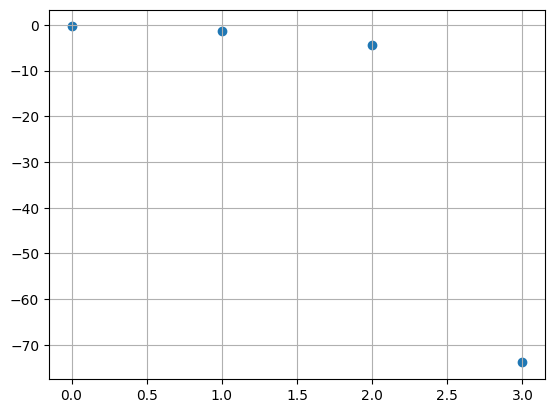

In [24]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(data_var_expl_ratio)),np.log(data_var_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

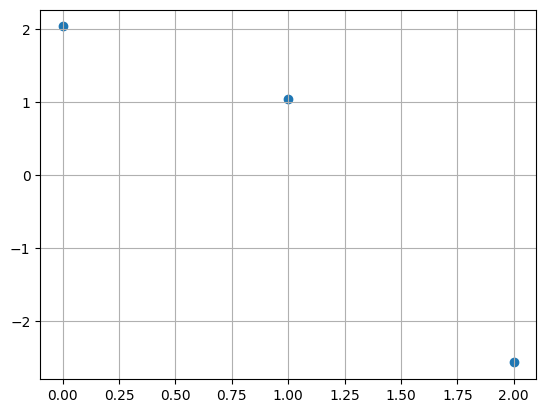

In [25]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(data_var_expl_ratio_E)),np.log(data_var_expl_ratio_E))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

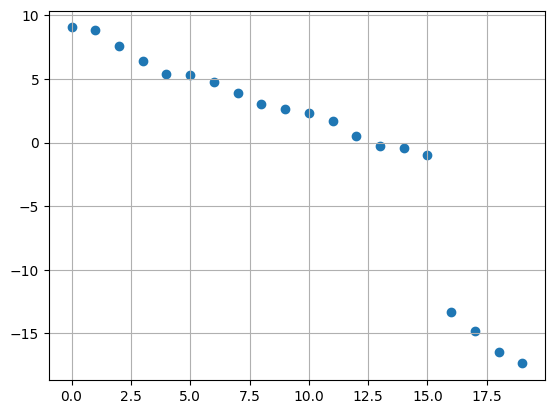

In [26]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(candid_lib_E_rem_sing_values_)),np.log(candid_lib_E_rem_sing_values_))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

In [27]:
candid_lib_E_SES_rem_sing_values_

array([8.42652427e+03, 7.09777234e+03, 1.89345784e+03, 5.91472557e+02,
       2.22829996e+02, 1.90441519e+02, 1.11848871e+02, 5.01344322e+01,
       2.05565826e+01, 1.34742041e+01, 9.85046759e+00, 5.40242173e+00,
       1.60677670e+00, 7.53107444e-01, 6.40101460e-01, 3.58586937e-01,
       1.65608042e-06, 3.59603747e-07, 6.96928156e-08])

## Removing a term that is part of algebraic relationship coming from steady state formulation

- This will lead to drop in the dim of the null space and the dimension of the column space of data remains the same as expected. 

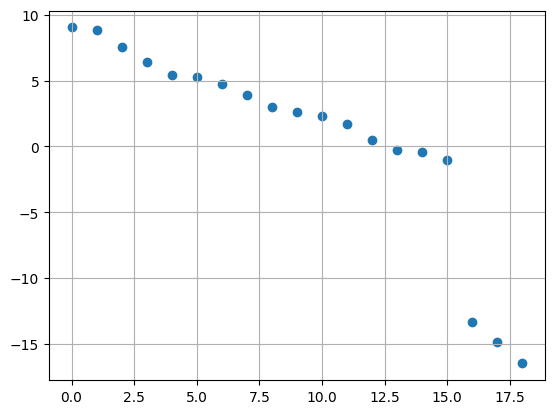

In [28]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(candid_lib_E_SES_rem_sing_values_)),np.log(candid_lib_E_SES_rem_sing_values_))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

## Removing a term that is not part of algebraic expression

- This will lead to drop in the dim of column space of data, but the null space dimension remains the same. 

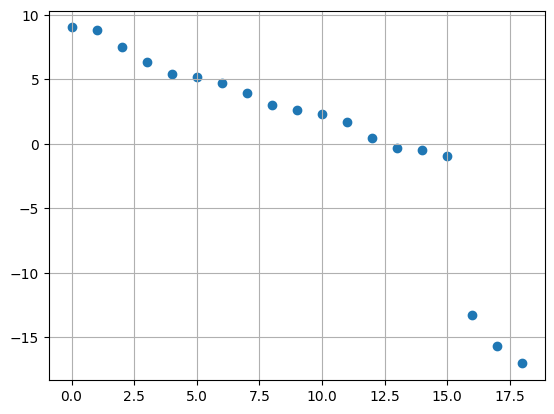

In [29]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(candid_lib_E_S2_rem_sing_values_)),np.log(candid_lib_E_S2_rem_sing_values_))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

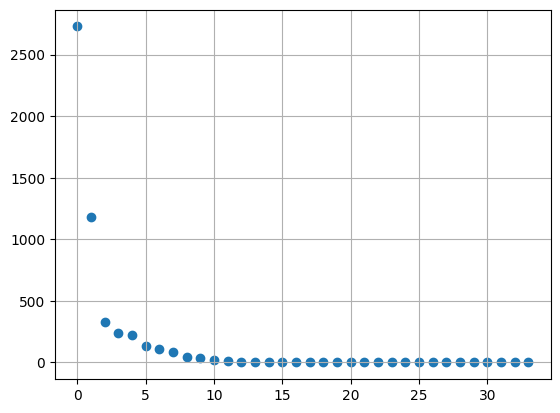

In [30]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(mean_cent_candid_lib_sing_values)),mean_cent_candid_lib_sing_values)
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

In [31]:
candid_lib_sing_values

array([8.53014594e+03, 7.11158665e+03, 1.92020429e+03, 7.12453793e+02,
       4.69969417e+02, 2.26925399e+02, 1.29370652e+02, 9.40715619e+01,
       5.15616827e+01, 2.83830434e+01, 1.91786887e+01, 8.31627562e+00,
       5.87389715e+00, 3.09321915e+00, 1.80074660e+00, 5.96725013e-01,
       3.79565769e-06, 7.57494803e-07, 2.53544796e-07, 9.32809277e-08,
       6.80752833e-13, 6.80752833e-13, 6.80752833e-13, 6.80752833e-13,
       6.80752833e-13, 6.80752833e-13, 6.80752833e-13, 6.80752833e-13,
       6.80752833e-13, 6.80752833e-13, 6.80752833e-13, 6.80752833e-13,
       6.80752833e-13, 1.52275607e-13])

In [32]:
mean_cent_candid_lib_sing_values


array([2.72844750e+03, 1.18042143e+03, 3.25525418e+02, 2.41576670e+02,
       2.22199331e+02, 1.33390445e+02, 1.09744655e+02, 8.36682981e+01,
       4.50513838e+01, 3.42863134e+01, 2.21275988e+01, 1.44404706e+01,
       7.80757107e+00, 6.21473596e+00, 3.86029126e+00, 7.60733050e-01,
       8.29682458e-07, 2.13279033e-07, 3.83053583e-08, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13, 2.15137910e-13, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13, 2.15137910e-13, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13, 2.15137910e-13, 2.15137910e-13,
       2.15137910e-13, 2.15137910e-13])

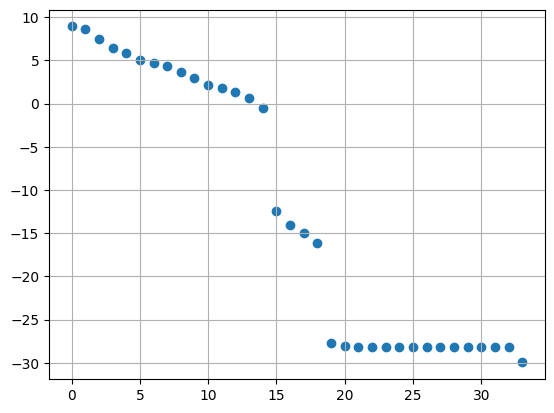

In [33]:
plt.scatter(np.arange(len(scaled_cand_lib_mean_sing_values)),np.log(scaled_cand_lib_mean_sing_values))
plt.grid()

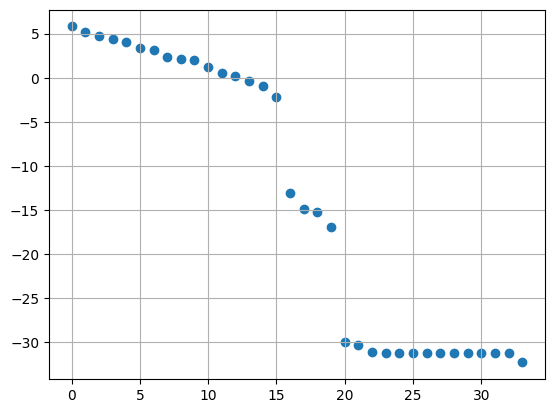

In [34]:
plt.scatter(np.arange(len(column_scaled_sing_values)),np.log(column_scaled_sing_values))
plt.grid()

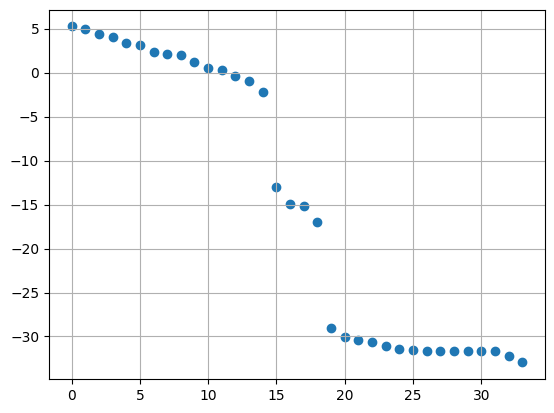

In [35]:
plt.scatter(np.arange(len(all_scaled_sing_values)),np.log(all_scaled_sing_values))
plt.grid()

In [36]:
from sklearn import decomposition
pca_2 = decomposition.PCA()
pca_2.fit(scaled_cand_lib)

thresh = 0.1

singular_values = pca_2.singular_values_
print("singular values are: {}".format(singular_values))
feature_names = pca_2.feature_names_in_
norm_singular_values = singular_values/singular_values[0]

alg_rel_dict = {}
for ind,sing_value in enumerate(norm_singular_values):
    if abs(sing_value) <10**-2:
        print("singular value is: {}".format(sing_value))
        pca_comp = pca_2.components_[ind]
        pca_comp[abs(pca_comp) < thresh] = 0
        alg_rel_dict[ind] = dict(zip(feature_names, pca_comp))
        alg_rel_dict[ind]["singular_value"] = sing_value
        # print(alg_rel_dict[ind])
        
alg_rel_df = pd.DataFrame(alg_rel_dict)
alg_rel_df

singular values are: [1.89829518e+02 1.41042227e+02 8.23745111e+01 6.06988571e+01
 2.86433603e+01 2.30304294e+01 1.08947683e+01 8.09709496e+00
 7.14862219e+00 3.21231969e+00 1.76991598e+00 1.27633849e+00
 6.94664825e-01 3.91921480e-01 1.07659213e-01 2.18294356e-06
 3.31717809e-07 2.64062347e-07 4.37174587e-08 1.75724540e-13
 8.62153976e-14 5.22955313e-14 3.94894491e-14 2.27662451e-14
 2.17466021e-14 1.76405453e-14 1.76405453e-14 1.76405453e-14
 1.76405453e-14 1.76405453e-14 1.76405453e-14 1.76405453e-14
 1.76405453e-14 5.67652913e-15]
singular value is: 0.009323713188623304
singular value is: 0.006723603891353114
singular value is: 0.0036594141496518406
singular value is: 0.00206459713773736
singular value is: 0.0005671363099946042
singular value is: 1.1499494799420643e-08
singular value is: 1.7474511433513083e-09
singular value is: 1.3910499778029282e-09
singular value is: 2.302985281299382e-10
singular value is: 9.256965991875297e-16
singular value is: 4.541727669599541e-16
singular 

10          11          12          13          14  \
[S]             0.00000000  0.19960771  0.00000000  0.00000000  0.20290504   
[E]             0.00000000  0.12248519  0.00000000  0.00000000  0.00000000   
[ES]            0.00000000 -0.12248519  0.00000000  0.00000000  0.00000000   
[P]             0.00000000  0.00000000 -0.13737219  0.00000000  0.00000000   
[S]^2           0.00000000  0.15639789  0.00000000  0.00000000 -0.45873903   
[S] [E]         0.00000000 -0.12248498  0.00000000  0.00000000  0.00000000   
[S] [ES]        0.00000000  0.25044497  0.00000000  0.00000000  0.24138651   
[S] [P]         0.10272290  0.00000000 -0.14051714 -0.35726413  0.00000000   
[E]^2           0.00000000  0.00000000  0.00000000  0.00000000  0.00000000   
[E] [ES]        0.00000000  0.12519787  0.00000000  0.00000000  0.00000000   
[E] [P]         0.00000000  0.00000000 -0.26313147  0.00000000  0.00000000   
[ES]^2          0.00000000 -0.17332188  0.00000000  0.00000000  0.00000000   
[ES] [P]        0.00000000  0.00000000  0.00000000  0.14252288  0.00000000   
[P]^2           0.00000000  0.00000000  0.37146440 -0.22340110  0.00000000   
[S]^3           0.15092447 -0.51115253  0.00000000  0.00000000  0.39509065   
[S]^2 [E]       0.00000000  0.25044499  0.00000000  0.00000000  0.24138662   
[S]^2 [ES]      0.00000000  0.13979996  0.00000000  0.00000000 -0.57272742   
[S]^2 [P]       0.00000000 -0.13082041  0.14040593  0.36899651  0.00000000   
[S] [E]^2       0.00000000  0.12519839  0.00000000  0.00000000  0.00000000   
[S] [E] [ES]    0.00000000 -0.17332180  0.00000000  0.00000000  0.00000000   
[S] [E] [P]     0.00000000  0.00000000  0.00000000  0.14252243  0.00000000   
[S] [ES]^2      0.00000000  0.32296490  0.00000000  0.00000000  0.29272244   
[S] [ES] [P]    0.15324554  0.00000000 -0.21016936 -0.49873282 -0.10396171   
[S] [P]^2       0.41097044  0.17406771  0.00000000  0.31972983  0.00000000   
[E]^3           0.00000000  0.00000000  0.00000000  0.00000000  0.00000000   
[E]^2 [ES]     -0.12572850  0.00000000  0.00000000  0.00000000  0.00000000   
[E]^2 [P]      -0.23067867  0.00000000 -0.22740032  0.00000000  0.00000000   
[E] [ES]^2      0.00000000  0.24997804  0.00000000  0.00000000  0.00000000   
[E] [ES] [P]    0.48888689  0.00000000 -0.16306109  0.00000000  0.00000000   
[E] [P]^2       0.30958578  0.00000000  0.52956144  0.00000000  0.00000000   
[ES]^3          0.00000000 -0.26495145  0.00000000  0.00000000  0.00000000   
[ES]^2 [P]     -0.38379728  0.00000000  0.23392055  0.18784726  0.00000000   
[ES] [P]^2     -0.37754018 -0.23975818  0.00000000 -0.37848804  0.00000000   
[P]^3          -0.18833067  0.00000000 -0.47372620  0.21134474  0.00000000   
singular_value  0.00932371  0.00672360  0.00365941  0.00206460  0.00056714   

                        15          16          17          18          19  \
[S]             0.00000000  0.00000000  0.00000000 -0.26296778  0.00000000   
[E]             0.00000000  0.00000000  0.16550989  0.00000000 -0.31543883   
[ES]            0.00000000  0.00000000 -0.16550990  0.00000000 -0.21569885   
[P]             0.00000000  0.14926290  0.00000000  0.00000000  0.00000000   
[S]^2           0.00000000  0.00000000  0.00000000  0.00000000  0.10520807   
[S] [E]        -0.26776311  0.10086040  0.44711312 -0.22843367  0.28454592   
[S] [ES]        0.00000000  0.00000000 -0.10181834 -0.26190152 -0.31751942   
[S] [P]         0.00000000 -0.11966688  0.00000000  0.00000000  0.00000000   
[E]^2          -0.13328991  0.00000000  0.11752222  0.00000000  0.00000000   
[E] [ES]        0.27025568 -0.15514324  0.11521072  0.00000000  0.00000000   
[E] [P]         0.00000000  0.00000000  0.00000000  0.00000000  0.14173172   
[ES]^2          0.00000000  0.00000000 -0.21862836  0.00000000 -0.16309553   
[ES] [P]        0.14060874  0.26140561  0.00000000  0.00000000  0.31870475   
[P]^2           0.00000000  0.00000000  0.00000000  0.00000000  0.00000000   
[S]^3           0.00000000  0.00000000  0.000

## PCA to track how dropping improves the null space. 

In [52]:
from matplotlib import pyplot as plt

In [53]:
drop_list = ["ES", "S E", "E", "S", "P", "E^2"]



KeyError: "['ES', 'S E', 'E', 'S', 'P', 'E^2'] not found in axis"

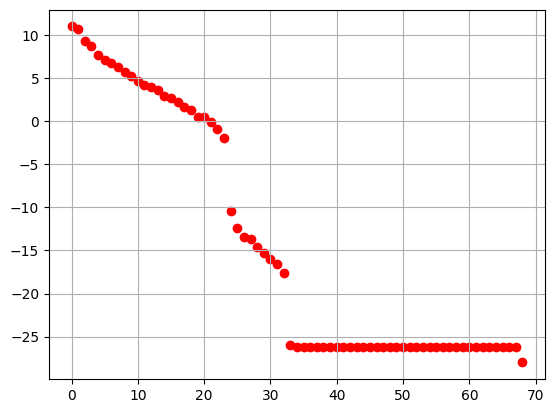

In [54]:
sing_values = np.linalg.svd(scaled_cand_lib_mean)[1]
plt.scatter(np.arange(len(sing_values)),np.log(sing_values), c='red')
plt.grid()

dropped_df = scaled_cand_lib_mean

dropped_df = dropped_df.drop(drop_list, axis=1)
sing_values = np.linalg.svd(dropped_df)[1]
plt.scatter(np.arange(len(sing_values)),np.log(sing_values))
# plt.grid()
# for feat in drop_list:
#     dropped_df = dropped_df.drop([feat], axis=1)
#     sing_values = np.linalg.svd(dropped_df)[1]
#     plt.scatter(np.arange(len(sing_values)),np.log(sing_values))
#     plt.grid()


In [ ]:
dropped_df

In [ ]:
sing_values

# Using Sequential Thresholding

### Using sympy to find factors of redundant feature and refine the library

In [45]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

## Testing dynamics finding 

In [46]:
# if poly_degree == 2:
#     refined_candid_lib = candidate_lib_E_rem.drop(['1', '[S] [ES]'], axis=1)
# elif poly_degree == 3:
#     refined_candid_lib = candidate_lib_E_rem.drop(['1', '[S] [ES]','[S]^2 [ES]','[S] [ES]^2', '[S] [ES] [P]' ], axis=1)
# elif poly_degree == 4:
#     refined_candid_lib = candidate_lib_E_rem.drop(['1', '[S] [ES]','[S]^2 [ES]','[S] [ES]^2', '[S] [ES] [P]', '[S]^3 [ES]', '[S]^2 [ES]^2', '[S]^2 [ES] [P]',
#                                                   '[S] [ES]^3', '[S] [ES]^2 [P]', '[S] [ES] [P]^2'], axis=1)


In [47]:
features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

## Refined candidate library is able to find the model 

In [48]:
from dae_finder import sequentialThLin

seq_th_model = sequentialThLin(fit_intercept=False)

seq_th_model.fit(X=refined_candid_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

Sequential threshold converged in 2 iterations


In [49]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'1': 0.0,
 '[S]': 0.0,
 '[ES]': 1.5087238232153457,
 '[P]': 0.0,
 '[S]^2': 0.0,
 '[S] [P]': 0.0,
 '[ES]^2': 0.0,
 '[ES] [P]': 0.0,
 '[P]^2': 0.0,
 '[S]^3': 0.0,
 '[S]^2 [P]': 0.0,
 '[S] [P]^2': 0.0,
 '[ES]^3': 0.0,
 '[ES]^2 [P]': 0.0,
 '[ES] [P]^2': 0.0,
 '[P]^3': 0.0}

## Full candidate library is unable to find the model 

In [50]:
from dae_finder import sequentialThLin

seq_th_model = sequentialThLin(fit_intercept=False, coef_threshold=0.05)

seq_th_model.fit(X=candidate_lib_full,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

Sequential threshold converged in 3 iterations


In [51]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'1': 0.0,
 '[S]': 0.0,
 '[E]': 0.0,
 '[ES]': 0.14794292835960257,
 '[P]': 0.0,
 '[S]^2': 0.0,
 '[S] [E]': 0.18178396306317637,
 '[S] [ES]': 0.0,
 '[S] [P]': 0.0,
 '[E]^2': 0.0,
 '[E] [ES]': 0.14798298259888093,
 '[E] [P]': 0.0,
 '[ES]^2': 0.1479028741210222,
 '[ES] [P]': 0.0,
 '[P]^2': 0.0,
 '[S]^3': 0.0,
 '[S]^2 [E]': 0.0,
 '[S]^2 [ES]': 0.0,
 '[S]^2 [P]': 0.0,
 '[S] [E]^2': 0.1818331800311651,
 '[S] [E] [ES]': 0.1817347460978628,
 '[S] [E] [P]': 0.0,
 '[S] [ES]^2': 0.0,
 '[S] [ES] [P]': 0.0,
 '[S] [P]^2': 0.0,
 '[E]^3': 0.0,
 '[E]^2 [ES]': 0.09927385474813767,
 '[E]^2 [P]': 0.0,
 '[E] [ES]^2': 0.1966921104521571,
 '[E] [ES] [P]': 0.0,
 '[E] [P]^2': 0.0,
 '[ES]^3': 0.09911363779124836,
 '[ES]^2 [P]': 0.0,
 '[ES] [P]^2': 0.0,
 '[P]^3': 0.0}

## Finding the conservation laws

In [52]:
from dae_finder import sequentialThLin, AlgModelFinder
seq_th_model = sequentialThLin(fit_intercept=True)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(data_matrix_df_smooth, scale_columns= False)

Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x156201f10>)

In [53]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models(5)

[E]        [ES]         [S]         [P]
[S]         0.00000000  0.00000000         NaN -0.74690808
[ES]       -0.99856266         NaN  1.62141460  0.79219631
[P]         0.00000000  0.00000000 -0.24969523         NaN
[E]                NaN -0.99856266 -1.62141460 -0.79219631
r2- metric  0.99999793  0.99999793  0.79824154  0.25213263

In [54]:
algebraic_model_th.get_fitted_intercepts()

{'[S]': 3.368292478790318,
 '[E]': 1.998590357425483,
 '[ES]': 1.9985349632868106,
 '[P]': 5.529204842775838}

### Finding the remaining algebraic relationships

In [56]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)


seq_th_model = sequentialThLin(fit_intercept=False, coef_threshold=0.05)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)
algebraic_model_th.fit(refined_candid_lib.drop(['1'], axis=1), scale_columns= False)

Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 0 iterations


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x155ef6190>)

In [57]:
algebraic_model_th.best_models(5)

[S] [P]  [S] [ES] [P]      [S]^2  [S]^2 [ES]    [ES] [P]
[S]          0.00000000    0.00000000 0.07491497 -0.37464665  0.00000000
[ES]         0.00000000    0.00000000 0.00000000  0.17994845  0.00000000
[P]          0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[S]^2        0.00000000    0.00000000        NaN  1.99179970  0.00000000
[S] [ES]     0.00000000    0.00000000 0.17592859 -0.97040381  0.00000000
[ES]^2       0.00000000    0.00000000 0.13296137  0.12042674  0.00000000
[ES] [P]     0.61432261   -1.22835221 0.00000000  0.00000000         NaN
[P]^2        0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[S]^3        0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[S]^2 [ES]   0.00000000    0.00000000 0.50133605         NaN  0.00000000
[S]^2 [P]    0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[S] [ES]^2   0.00000000    0.00000000 0.18848170  0.00000000  0.00000000
[S] [ES] [P] 0.50001201           NaN 0.00000000  0.00000000 -0.81344269
[S] [P]^2    0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[ES]^3       0.00000000    0.00000000 0.07713776 -0.14215062  0.00000000
[ES]^2 [P]   0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[ES] [P]^2   0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[P]^3        0.00000000    0.00000000 0.00000000  0.00000000  0.00000000
[S] [P]             NaN    1.99981855 0.00000000  0.00000000  1.62708675
r2- metric   1.00000000    1.00000000 0.99999998  0.99999997  0.99999992

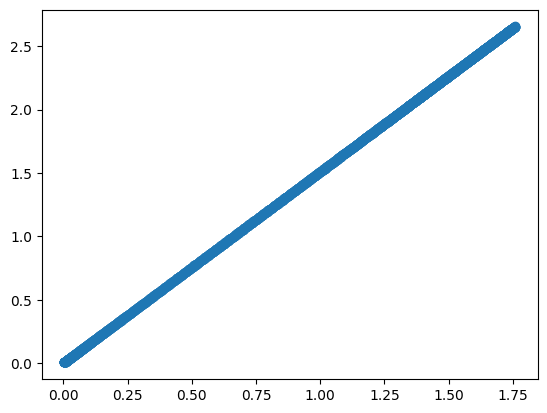

In [67]:
plt.scatter(data_matrix_df_smooth_appended['[ES]'], data_matrix_df_smooth_appended['d([P]) /dt'])

# Using Lasso

## Testing dynamics finding 

## Refined candidate library is able to find the model 

In [58]:
from dae_finder import sequentialThLin

seq_th_model = sequentialThLin(fit_intercept=False)

seq_th_model.fit(X=candidate_lib_full,  y=data_matrix_df_smooth_appended['d([P]) /dt'])


from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)

Sequential threshold converged in 2 iterations


In [59]:
from sklearn.linear_model import Lasso
alg_lasso = Lasso(fit_intercept=False)
alg_lasso.fit(X=scaled_refined_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

Lasso(fit_intercept=False)

In [60]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

{'1': 0.0,
 '[S]': 0.0,
 '[ES]': 0.6242195578178206,
 '[P]': 0.0,
 '[S]^2': 0.0,
 '[S] [ES]': 0.0,
 '[S] [P]': 0.0,
 '[ES]^2': 0.0,
 '[ES] [P]': 0.0,
 '[P]^2': 0.0,
 '[S]^3': 0.0,
 '[S]^2 [ES]': 0.0,
 '[S]^2 [P]': 0.0,
 '[S] [ES]^2': 0.0,
 '[S] [ES] [P]': 0.0,
 '[S] [P]^2': 0.0,
 '[ES]^3': 0.0,
 '[ES]^2 [P]': 0.0,
 '[ES] [P]^2': 0.0,
 '[P]^3': 0.0}

## Full candidate library is unable to find the model 

In [61]:
alg_lasso.fit(X=candidate_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

Lasso(fit_intercept=False)

In [62]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

{'[S]': 0.0,
 '[E]': 0.0,
 '[ES]': 0.0,
 '[P]': 0.0,
 '[S]^2': 0.0,
 '[S] [E]': 0.0,
 '[S] [ES]': 0.0,
 '[S] [P]': 0.0,
 '[E]^2': 0.0,
 '[E] [ES]': 0.0,
 '[E] [P]': 0.0,
 '[ES]^2': 0.0,
 '[ES] [P]': 0.0,
 '[P]^2': 0.011011850739963126,
 '[S]^3': -0.01159473498101463,
 '[S]^2 [E]': 0.0,
 '[S]^2 [ES]': 0.07805942184739562,
 '[S]^2 [P]': 0.0,
 '[S] [E]^2': 0.0,
 '[S] [E] [ES]': 0.0,
 '[S] [E] [P]': 0.0,
 '[S] [ES]^2': 0.0,
 '[S] [ES] [P]': 0.0,
 '[S] [P]^2': 0.005083970579360144,
 '[E]^3': 0.0,
 '[E]^2 [ES]': 0.0,
 '[E]^2 [P]': 0.0,
 '[E] [ES]^2': 0.0,
 '[E] [ES] [P]': 0.0,
 '[E] [P]^2': 0.00041076000099417564,
 '[ES]^3': 0.0,
 '[ES]^2 [P]': 0.0,
 '[ES] [P]^2': 0.017727404107773452,
 '[P]^3': -0.0011179641832239772}

## Finding the conservation laws

In [63]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)

AlgModelFinder(fit_intercept=True)

In [64]:
#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

[E]        [ES]         [S]         [P]
[S]        -0.00000000  0.00000000         NaN -0.31688963
[ES]       -0.90000000         NaN  0.00000000  0.00000000
[P]         0.00000000 -0.00000000 -0.16290900         NaN
[E]                NaN -0.90000000 -2.93069101 -0.00000000
r2- metric  0.99000000  0.99000000  0.78266184  0.19461424

In [65]:
algebraic_model_lasso.get_fitted_intercepts()

{'[S]': 5.971262752851987,
 '[E]': 1.9024026277286452,
 '[ES]': 1.8985477286698578,
 '[P]': 4.478104796633372}

### Finding the remaining algebraic relationships

In [69]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.3)
algebraic_model_lasso.fit(refined_candid_lib.drop(['1'], axis=1), scale_columns= True)

AlgModelFinder(alpha=0.3)

In [68]:
algebraic_model_lasso.best_models(5)

[S] [P]      [ES]^3         [S]      [ES]^2    [S] [ES]
[S]          0.00000000  0.09635509         NaN  0.00000000  1.35280978
[ES]         0.89311516  0.03710198  1.03093782  0.97495528  0.00000000
[P]          0.00000000  0.00000000  0.00000000 -0.00000000  0.00000000
[S]^2        0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[S] [ES]     0.00000000  0.00000000  0.32385571  0.00000000         NaN
[ES]^2       0.00000000  1.12184880  0.00000000         NaN  0.00000000
[ES] [P]     0.07751941  0.00000000  0.00000000  0.00000000  0.00000000
[P]^2        0.00000000 -0.00000000 -0.00000000 -0.00000000 -0.00000000
[S]^3        0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[S]^2 [ES]   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[S]^2 [P]    0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[S] [ES]^2   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[S] [ES] [P] 0.25725428  0.00000000  0.00000000  0.00000000  0.00000000
[S] [P]^2    0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[ES]^3       0.00000000         NaN  0.00000000  0.14983024  0.00000000
[ES]^2 [P]   0.56528849  0.00000000  0.00000000  0.00000000  0.00000000
[ES] [P]^2   0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[P]^3        0.00000000 -0.00000000 -0.00000000 -0.00000000 -0.00000000
[S] [P]             NaN  0.00000000  0.00000000  0.00000000  0.00000000
r2- metric   0.94266578  0.93887528  0.93883329  0.93774966  0.93761996

In [70]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True, alpha=0.3)
algebraic_model_lasso.fit(refined_candid_lib.drop(['1'], axis=1), scale_columns= True)

AlgModelFinder(alpha=0.3, fit_intercept=True)

In [71]:
algebraic_model_lasso.best_models(5)

[S] [ES]  [S]^2 [ES]       [S]^2  [S] [ES]^2         [S]
[S]           0.52828097  0.00000000  0.00000000  0.00000000         NaN
[ES]          0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[P]          -0.00000000 -0.00000000 -0.00000000 -0.00000000 -0.00000000
[S]^2         0.00000000  1.12939615         NaN  0.04683553  0.00000000
[S] [P]       0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[ES]^2        0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[ES] [P]      0.00000000 -0.00000000  0.00000000  0.00000000  0.00000000
[P]^2        -0.00000000 -0.00000000 -0.00000000 -0.00000000 -0.00000000
[S]^3         0.00000000  0.00998861  0.00000000  0.00000000  0.00000000
[S]^2 [ES]    0.00000000         NaN  0.38956197  0.00000000  0.00000000
[S]^2 [P]     0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[S] [ES]^2    0.23165713  0.00000000  0.07156899         NaN  0.00000000
[S] [ES] [P]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[S] [P]^2     0.00000000 -0.00000000  0.00000000  0.00000000  0.00000000
[ES]^3        0.00000000  0.00000000  0.00000000  0.00000000  0.16291807
[ES]^2 [P]    0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[ES] [P]^2   -0.00000000 -0.00000000 -0.00000000 -0.00000000  0.00000000
[P]^3        -0.00000000 -0.00000000 -0.00000000 -0.00000000 -0.00000000
[S] [ES]             NaN  0.00000000  0.00000000  1.00399429  0.33174276
r2- metric    0.90930963  0.90889834  0.90884937  0.90777565  0.90622289

In [80]:
algebraic_model_lasso.get_fitted_intercepts()

{'[S]': 0.9003740556449316,
 '[ES]': 0.4901827039036051,
 '[P]': 2.303314332136872,
 '[S]^2': 3.7198722475738437,
 '[S] [ES]': 1.0212568824568635,
 '[S] [P]': 2.437682945715927,
 '[ES]^2': 0.37507497748544727,
 '[ES] [P]': 1.4294649374786772,
 '[P]^2': 4.516409402704352,
 '[S]^3': 21.638101567066894,
 '[S]^2 [ES]': 5.42496938787425,
 '[S]^2 [P]': 7.825586575762572,
 '[S] [ES]^2': 1.6210431034143418,
 '[S] [ES] [P]': 2.662908646751478,
 '[S] [P]^2': 9.538817602217904,
 '[ES]^3': 0.5571847231258493,
 '[ES]^2 [P]': 1.2224240243384605,
 '[ES] [P]^2': 5.694570407202795,
 '[P]^3': 29.342511636295644,
 '[S]^4': 89.60599239450927,
 '[S]^3 [ES]': 30.991875396400367,
 '[S]^3 [P]': 25.386786076322576,
 '[S]^2 [ES]^2': 8.163908573865623,
 '[S]^2 [ES] [P]': 9.94713100734605,
 '[S]^2 [P]^2': 13.285755119279148,
 '[S] [ES]^3': 2.318475318508902,
 '[S] [ES]^2 [P]': 3.5056507864811803,
 '[S] [ES] [P]^2': 8.447776518774532,
 '[S] [P]^3': 30.524992093343254,
 '[ES]^4': 0.7262718657035299,
 '[ES]^3 [P]': 

In [81]:
from sklearn.linear_model import LassoCV

In [82]:
lass_cv = LassoCV(fit_intercept=True)

In [83]:
lass_cv.fit(X=candidate_lib_E_rem.drop(['1', 'S'], axis=1),  y=candidate_lib_E_rem['S'])

KeyError: "['S'] not found in axis"

In [84]:
dict(zip(lass_cv.feature_names_in_, lass_cv.coef_))

AttributeError: 'LassoCV' object has no attribute 'feature_names_in_'

In [85]:
lass_cv

LassoCV()

In [86]:
candidate_lib_E_rem

1        [S]       [ES]         [P]      [S]^2   [S] [ES]  \
0    1.00000000 3.00000000 1.41886107 -0.00000000 9.00000000 4.25658321   
1    1.00000000 2.97855386 1.41589878  0.02144614 8.87178309 4.21733077   
2    1.00000000 2.95715270 1.41291245  0.04284730 8.74475209 4.17819788   
3    1.00000000 2.93579690 1.40990187  0.06420310 8.61890343 4.13918554   
4    1.00000000 2.91448684 1.40686680  0.08551316 8.49423351 4.10029476   
...         ...        ...        ...         ...        ...        ...   
1995 1.00000000 0.52896873 0.60188309  8.47103127 0.27980792 0.31837733   
1996 1.00000000 0.51991644 0.59464553  8.48008356 0.27031310 0.30916599   
1997 1.00000000 0.51097356 0.58742149  8.48902644 0.26109398 0.30015685   
1998 1.00000000 0.50213995 0.58021236  8.49786005 0.25214453 0.29134781   
1999 1.00000000 0.49341544 0.57301952  8.50658456 0.24345880 0.28273668   

         [S] [P]     [ES]^2    [ES] [P]       [P]^2  ...  [S]^2 [P]^2  \
0    -0.00000000 2.01316674 -0.00000000  0.00000000  ...   0.00000000   
1     0.06387849 2.00476935  0.03036557  0.00045994  ...   0.00408046   
2     0.12670601 1.99632160  0.06053949  0.00183589  ...   0.01605441   
3     0.18848727 1.98782328  0.09052007  0.00412204  ...   0.03552745   
4     0.24922699 1.97927419  0.12030563  0.00731250  ...   0.06211409   
...          ...        ...         ...         ...  ...          ...   
1995  4.48091066 0.36226325  5.09857046 71.75837075  ...  20.07856038   
1996  4.40893484 0.35360331  5.04264380 71.91181722  ...  19.43870641   
1997  4.33766809 0.34506401  4.98663658 72.06356984  ...  18.81536447   
1998  4.26711503 0.33664638  4.93056342 72.21362541  ...  18.20827067   
1999  4.19728018 0.32835137  4.87443901 72.36198085  ...  17.61716087   

      [S] [ES]^3  [S] [ES]^2 [P]  [S] [ES] [P]^2    [S] [P]^3     [ES]^4  \
0     8.56921172     -0.00000000      0.00000000  -0.00000000 4.05284030   
1     8.45477547      0.12806163      0.00193971   0.00002938 4.01910015   
2     8.34102669      0.25294595      0.00767072   0.00023262 3.98529995   
3     8.22796939      0.37467938      0.01706188   0.00077695 3.95144141   
4     8.11560760      0.49328856      0.02998341   0.00182247 3.91752632   
...          ...             ...             ...          ...        ...   
1995  0.11533641      1.62326927     22.84623874 321.54284877 0.13123466   
1996  0.10932212      1.55901395     22.23268794 317.05451621 0.12503530   
1997  0.10357333      1.49677314     21.63037436 312.58784739 0.11906917   
1998  0.09808118      1.43650883     21.03928127 308.14384629 0.11333079   
1999  0.09283698      1.37818270     20.45938622 303.72350770 0.10781462   

      [ES]^3 [P]  [ES]^2 [P]^2   [ES] [P]^3         [P]^4  
0    -0.00000000    0.00000000  -0.00000000    0.00000000  
1     0.06087595    0.00092207   0.00001397    0.00000021  
2     0.12085628    0.00366503   0.00011114    0.00000337  
3     0.17993791    0.00819388   0.00037313    0.00001699  
4     0.23811783    0.01447345   0.00087974    0.00005347  
...          ...           ...          ...           ...  
1995  1.84702471   25.99542072 365.86510925 5149.26377298  
1996  1.78309554   25.42825654 362.62567957 5171.30945612  
1997  1.72070881   24.86654436 359.35483327 5193.15809743  
1998  1.65985633   24.31045564 356.05385991 5214.80769507  
1999  1.60052873   23.76015565 352.72406219 5236.25627261  

[2000 rows x 35 columns]

In [87]:
plt.scatter(candidate_lib_E_rem['ES'], candidate_lib_E_rem['ES^2'])

KeyError: 'ES'

In [88]:
candidate_lib_E_rem['ES'].plot()

KeyError: 'ES'

### Using sympy to find factors of redundant feature and refine the library

In [18]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [22]:
features_to_remove = {E, S*ES}

features_to_remove, refined_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

In [24]:
refined_lib

[S]       [ES]         [P]      [S]^2     [S] [P]     [ES]^2  \
0    3.00000000 1.41886107 -0.00000000 9.00000000 -0.00000000 2.01316674   
1    2.97855386 1.41589878  0.02144614 8.87178309  0.06387849 2.00476935   
2    2.95715270 1.41291245  0.04284730 8.74475209  0.12670601 1.99632160   
3    2.93579690 1.40990187  0.06420310 8.61890343  0.18848727 1.98782328   
4    2.91448684 1.40686680  0.08551316 8.49423351  0.24922699 1.97927419   
...         ...        ...         ...        ...         ...        ...   
1995 0.52896873 0.60188309  8.47103127 0.27980792  4.48091066 0.36226325   
1996 0.51991644 0.59464553  8.48008356 0.27031310  4.40893484 0.35360331   
1997 0.51097356 0.58742149  8.48902644 0.26109398  4.33766809 0.34506401   
1998 0.50213995 0.58021236  8.49786005 0.25214453  4.26711503 0.33664638   
1999 0.49341544 0.57301952  8.50658456 0.24345880  4.19728018 0.32835137   

        [ES] [P]       [P]^2       [S]^3   [S]^2 [P]  ...        [P]^3  \
0    -0.00000000  0.00000000 27.00000000 -0.00000000  ...  -0.00000000   
1     0.03036557  0.00045994 26.42508376  0.19026551  ...   0.00000986   
2     0.06053949  0.00183589 25.85956723  0.37468902  ...   0.00007866   
3     0.09052007  0.00412204 25.30334996  0.55336033  ...   0.00026465   
4     0.12030563  0.00731250 24.75633174  0.72636879  ...   0.00062532   
...          ...         ...         ...         ...  ...          ...   
1995  5.09857046 71.75837075  0.14800964  2.37026163  ... 607.86740242   
1996  5.04264380 71.91181722  0.14054023  2.29227770  ... 609.81821915   
1997  4.98663658 72.06356984  0.13341212  2.21643372  ... 611.74954942   
1998  4.93056342 72.21362541  0.12661184  2.14268893  ... 613.66128237   
1999  4.87443901 72.36198085  0.12012633  2.07100285  ... 615.55330892   

           [S]^4   [S]^3 [P]  [S]^2 [P]^2    [S] [P]^3     [ES]^4  [ES]^3 [P]  \
0    81.00000000 -0.00000000   0.00000000  -0.00000000 4.05284030 -0.00000000   
1    78.70853519  0.56671608   0.00408046   0.00002938 4.01910015  0.06087595   
2    76.47068904  1.10801266   0.01605441   0.00023262 3.98529995  0.12085628   
3    74.28549633  1.62455354   0.03552745   0.00077695 3.95144141  0.17993791   
4    72.15200295  2.11699228   0.06211409   0.00182247 3.91752632  0.23811783   
...          ...         ...          ...          ...        ...         ...   
1995  0.07829247  1.25379429  20.07856038 321.54284877 0.13123466  1.84702471   
1996  0.07306917  1.19179285  19.43870641 317.05451621 0.12503530  1.78309554   
1997  0.06817007  1.13253904  18.81536447 312.58784739 0.11906917  1.72070881   
1998  0.06357686  1.07592972  18.20827067 308.14384629 0.11333079  1.65985633   
1999  0.05927219  1.02186479  17.61716087 303.72350770 0.10781462  1.60052873   

      [ES]^2 [P]^2   [ES] [P]^3         [P]^4  
0       0.00000000  -0.00000000    0.00000000  
1       0.00092207   0.00001397    0.00000021  
2       0.00366503   0.00011114    0.00000337  
3       0.00819388   0.00037313    0.00001699  
4       0.01447345   0.00087974    0.00005347  
...            ...          ...           ...  
1995   25.99542072 365.86510925 5149.26377298  
1996   25.42825654 362.62567957 5171.30945612  
1997   24.86654436 359.35483327 5193.15809743  
1998   24.31045564 356.05385991 5214.80769507  
1999   23.76015565 352.72406219 5236.25627261  

[2000 rows x 24 columns]